In [17]:
import glob
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("max_colwidth", 100)
sns.set(rc={"figure.figsize": (30, 14)})

In [18]:
files_list = glob.glob("../results/bbcnews/*.json")
dfs = []
for f in files_list:
    embedding_retrieval_type = "_".join(f.split("_")[3:-1]) + "_pooling"
    df = pd.read_json(f)
    df["embedding_retrieval_type"] = embedding_retrieval_type
    dfs.append(df)

In [19]:
full_results = pd.concat(dfs)

In [20]:
full_results

,Dataset,Dataset Size,Model,Params,Scores,Computation Time,embedding_retrieval_type
0,./data/bbc_news,2225,BERTopic,"{'embedding_model': 'all-MiniLM-L12-v2', 'nr_topics': 10, 'min_topic_size': 15, 'verbose': True,...","{'npmi': 0.15539057576583, 'diversity': 0.9}",14.687779,embedding_concat_last_four_layers_max_pooling
1,./data/bbc_news,2225,BERTopic,"{'embedding_model': 'all-MiniLM-L12-v2', 'nr_topics': 20, 'min_topic_size': 15, 'verbose': True,...","{'npmi': 0.15539057576583, 'diversity': 0.9}",13.657315,embedding_concat_last_four_layers_max_pooling
2,./data/bbc_news,2225,BERTopic,"{'embedding_model': 'all-MiniLM-L12-v2', 'nr_topics': 30, 'min_topic_size': 15, 'verbose': True,...","{'npmi': 0.15539057576583, 'diversity': 0.9}",14.720695,embedding_concat_last_four_layers_max_pooling
3,./data/bbc_news,2225,BERTopic,"{'embedding_model': 'all-MiniLM-L12-v2', 'nr_topics': 40, 'min_topic_size': 15, 'verbose': True,...","{'npmi': 0.15539057576583, 'diversity': 0.9}",13.223419,embedding_concat_last_four_layers_max_pooling
4,./data/bbc_news,2225,BERTopic,"{'embedding_model': 'all-MiniLM-L12-v2', 'nr_topics': 50, 'min_topic_size': 15, 'verbose': True,...","{'npmi': 0.15539057576583, 'diversity': 0.9}",16.200952,embedding_concat_last_four_layers_max_pooling
...,...,...,...,...,...,...,...
0,./data/bbc_news,2225,BERTopic,"{'embedding_model': 'all-MiniLM-L12-v2', 'nr_topics': 10, 'min_topic_size': 15, 'verbose': True,...","{'npmi': 0.12521548365979102, 'diversity': 1.0}",11.046179,embedding_sum_last_four_layers_max_pooling
1,./data/bbc_news,2225,BERTopic,"{'embedding_model': 'all-MiniLM-L12-v2', 'nr_topics': 20, 'min_topic_size': 15, 'verbose': True,...","{'npmi': 0.12521548365979102, 'diversity': 1.0}",9.112238,embedding_sum_last_four_layers_max_pooling
2,./data/bbc_news,2225,BERTopic,"{'embedding_model': 'all-MiniLM-L12-v2', 'nr_topics': 30, 'min_topic_size': 15, 'verbose': True,...","{'npmi': 0.12521548365979102, 'diversity': 1.0}",10.339278,embedding_sum_last_four_layers_max_pooling
3,./data/bbc_news,2225,BERTopic,"{'embedding_model': 'all-MiniLM-L12-v2', 'nr_topics': 40, 'min_topic_size': 15, 'verbose': True,...","{'npmi': 0.12521548365979102, 'diversity': 1.0}",10.133058,embedding_sum_last_four_layers_max_pooling


In [21]:
keys_to_extract = ["embedding_model", "nr_topics", "min_topic_size"]
for key in keys_to_extract:
    full_results[key] = full_results["Params"].apply(lambda x: x.get(key, None))
full_results.drop("Params", axis=1, inplace=True)

In [22]:
keys_to_extract = ["npmi", "diversity"]
for key in keys_to_extract:
    full_results[key] = full_results["Scores"].apply(lambda x: x.get(key, None))
full_results.drop("Scores", axis=1, inplace=True)

In [23]:
results_grouped = full_results.groupby(
    [full_results["embedding_retrieval_type"], full_results["nr_topics"]], as_index=False
)[["nr_topics", "npmi", "diversity", "Computation Time"]].mean()

In [24]:
def rename_embedding_type(name):
    # Split the name into parts
    parts = name.split("_")

    # Define the new names for each part
    new_name_parts = {
        "concat": "Concat",
        "sum": "Sum",
        "last": "Last",
        "second": "Second",
        "all": "All",
        "four": "Four",
        "layers": "Layers",
        "layer": "Layer",
        "output": "Output",
        "hidden": "Hidden",
    }

    # Determine the pooling type and place it in parentheses
    pooling = parts[-2].upper() if parts[-2] == "cls" else parts[-2].capitalize()
    pooling_type = f"({pooling} Pooling)"

    # Check for 'embedding_layer' to include "Embedding Layer" in the new name
    if "_".join(parts[:2]) == "embedding_layer":
        new_name = "Embedding Layer " + " ".join(
            new_name_parts.get(part, part.capitalize()) for part in parts[2:-2]
        )
    else:
        new_name = " ".join(new_name_parts.get(part, part.capitalize()) for part in parts[1:-2])

    # Add the pooling type
    new_name += " " + pooling_type

    # Remove extra spaces and return
    return " ".join(new_name.split())

In [25]:
results_grouped["embedding_retrieval_type"] = [rename_embedding_type(name) for name in results_grouped["embedding_retrieval_type"]]

In [26]:
results_sorted_npmi = (
    results_grouped.groupby("embedding_retrieval_type")
    .mean("npmi")
    .reset_index()
    .sort_values("npmi", ascending=False)
)
top_categories_npmi = results_sorted_npmi.head(5)["embedding_retrieval_type"].tolist()

In [27]:
results_sorted_diversity = (
    results_grouped.groupby("embedding_retrieval_type")
    .mean("diversity")
    .reset_index()
    .sort_values("diversity", ascending=False)
)
results_sorted_diversity = results_sorted_diversity[results_sorted_diversity["embedding_retrieval_type"] != "Last Hidden Layer (CLS Pooling)"]
top_categories_diversity = results_sorted_diversity.head(5)["embedding_retrieval_type"].tolist()

In [28]:
top_categories_diversity

['Sum Last Four Layers (Max Pooling)',
 'Second Last Layer (Max Pooling)',
 'Sum All Layers (Max Pooling)',
 'Concat Last Four Layers (Max Pooling)',
 'Embedding Layer Output (Max Pooling)']

In [29]:
default_setting = results_grouped[
    results_grouped["embedding_retrieval_type"] == "Last Hidden Layer (CLS Pooling)"
]

results_grouped = results_grouped[
    results_grouped["embedding_retrieval_type"] != "Last Hidden Layer (CLS Pooling)"
]

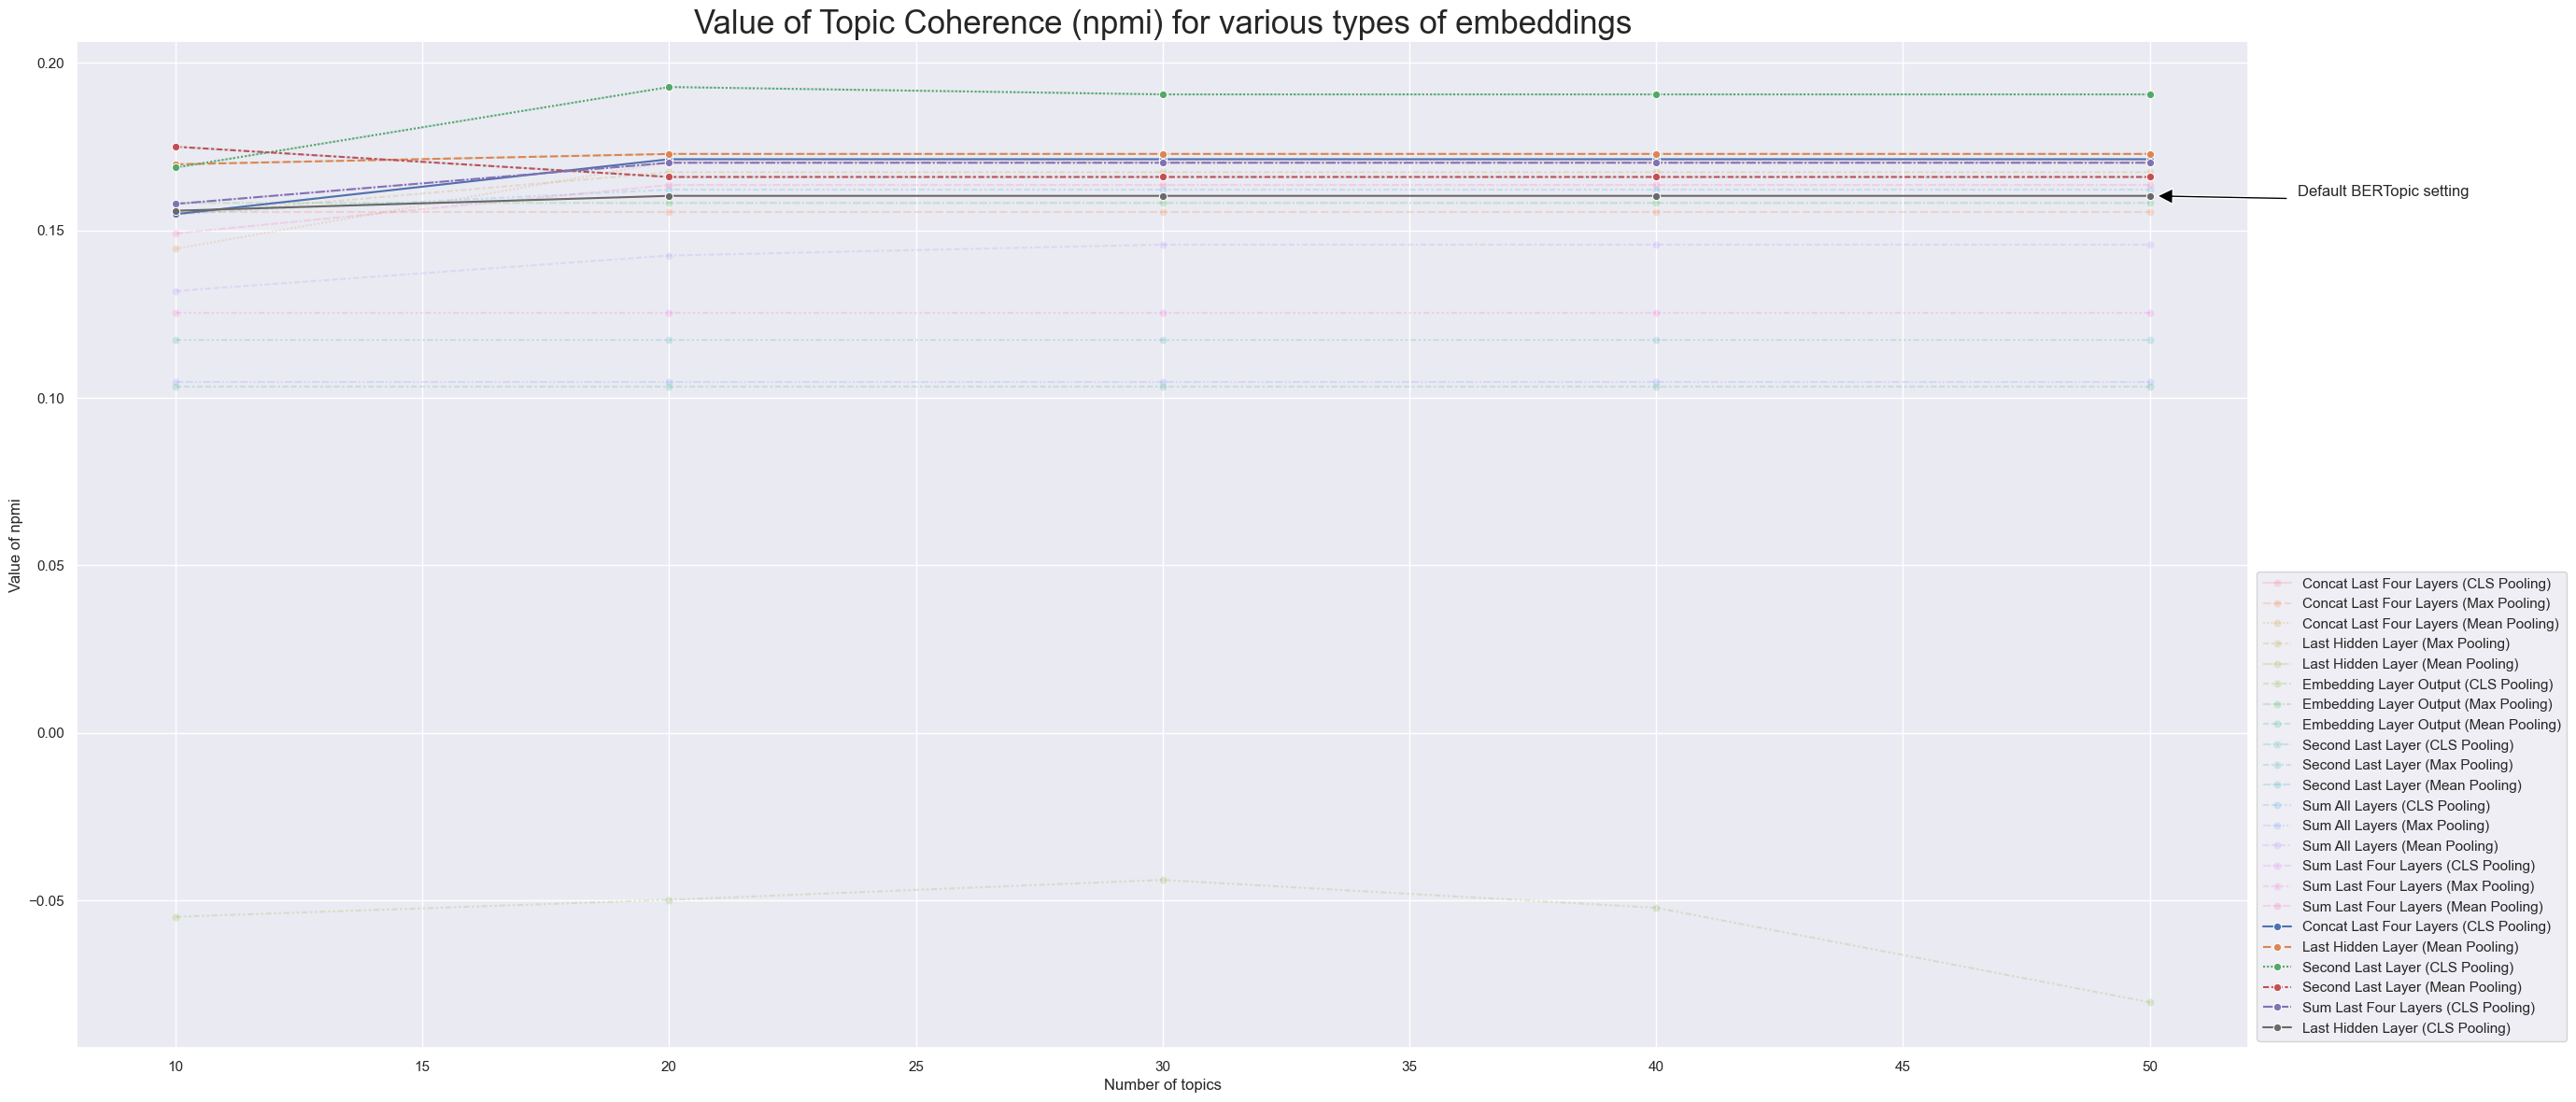

In [32]:
fig, ax = plt.subplots()
sns.lineplot(
    data=results_grouped,
    x="nr_topics",
    y="npmi",
    style="embedding_retrieval_type",
    hue="embedding_retrieval_type",
    alpha=0.2,
    marker="o",
    ax=ax,
)
sns.lineplot(
    data=results_grouped[results_grouped["embedding_retrieval_type"].isin(top_categories_npmi)],
    x="nr_topics",
    y="npmi",
    style="embedding_retrieval_type",
    hue="embedding_retrieval_type",
    alpha=1,
    marker="o",
    ax=ax,
)

sns.lineplot(
    data=default_setting,
    x="nr_topics",
    y="npmi",
    style="embedding_retrieval_type",
    color="dimgrey",
    alpha=1,
    marker="o",
    ax=ax,
)
plt.xlabel("Number of topics")
plt.ylabel("Value of npmi")
plt.title("Value of Topic Coherence (npmi) for various types of embeddings", size=25)

line = ax.lines[-2]
x_data = line.get_xdata()
y_data = line.get_ydata()
x_to_annotate = x_data[-1]
y_to_annotate = y_data[-1]

ax.annotate(
    "Default BERTopic setting",
    xy=(x_to_annotate, y_to_annotate),
    xytext=(x_to_annotate + 3, y_to_annotate),
    arrowprops=dict(facecolor="black", shrink=0.05, width=2),
)

ax.legend(loc="lower right", bbox_to_anchor=(1.15, 0))
plt.show()

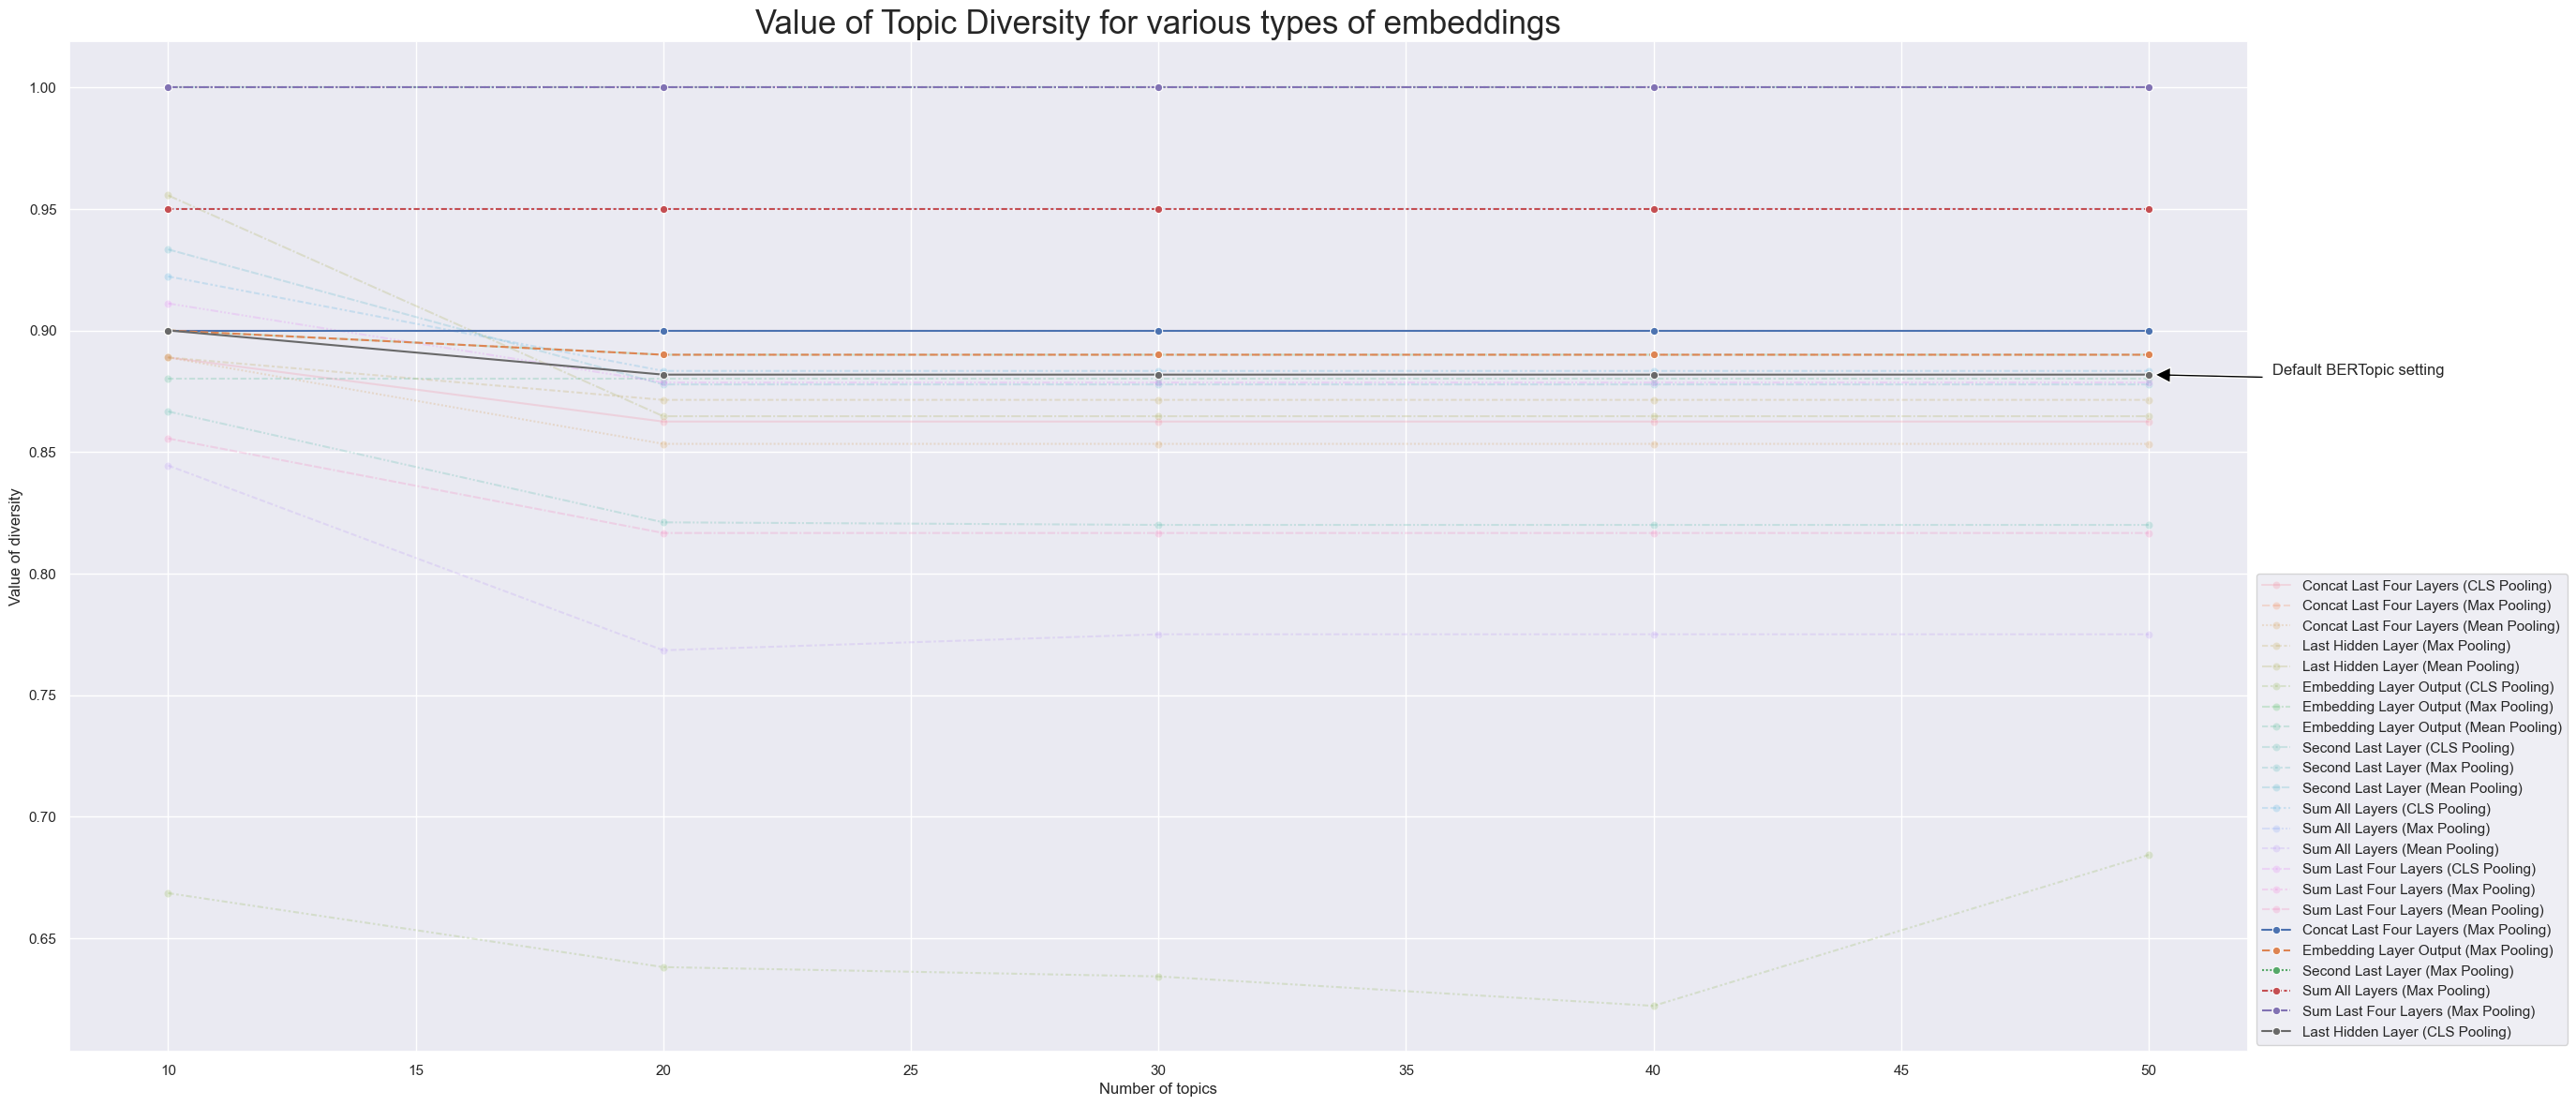

In [36]:
fig, ax = plt.subplots()
sns.lineplot(
    data=results_grouped,
    x="nr_topics",
    y="diversity",
    style="embedding_retrieval_type",
    hue="embedding_retrieval_type",
    alpha=0.2,
    marker="o",
    ax=ax,
)
sns.lineplot(
    data=results_grouped[results_grouped["embedding_retrieval_type"].isin(top_categories_diversity)],
    x="nr_topics",
    y="diversity",
    style="embedding_retrieval_type",
    hue="embedding_retrieval_type",
    alpha=1,
    marker="o",
    ax=ax,
)

sns.lineplot(
    data=default_setting,
    x="nr_topics",
    y="diversity",
    style="embedding_retrieval_type",
    color="dimgrey",
    alpha=1,
    marker="o",
    ax=ax,
)
plt.xlabel("Number of topics")
plt.ylabel("Value of diversity")
plt.title("Value of Topic Diversity for various types of embeddings", size=25)

line = ax.lines[-2]
x_data = line.get_xdata()
y_data = line.get_ydata()
x_to_annotate = x_data[-1]
y_to_annotate = y_data[-1]

ax.annotate(
    "Default BERTopic setting",
    xy=(x_to_annotate, y_to_annotate),
    xytext=(x_to_annotate + 2.5, y_to_annotate),
    arrowprops=dict(facecolor="black", shrink=0.05, width=2),
)

ax.legend(loc="lower right", bbox_to_anchor=(1.15, 0))
plt.show()